In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # colab do not support cv2.imshow()

# Variables

In [2]:
ROOT_COLAB = '/content/drive/MyDrive/Colab Notebooks'
YOLO_CONFIG = ROOT_COLAB + '/YOLO/oc_data/'
COCO_LABELS_FILE = YOLO_CONFIG + 'coco.names'
YOLO_CONFIG_FILE = YOLO_CONFIG + 'yolov3.cfg'
YOLO_WEIGHTS_FILE = YOLO_CONFIG + 'yolov3.weights'
IMAGE_FILE = 'yoloimg.jpg'
IMAGE = cv2.imread(ROOT_COLAB + '/' + IMAGE_FILE)
CONFIDENCE_MIN = 0.5

# Show image

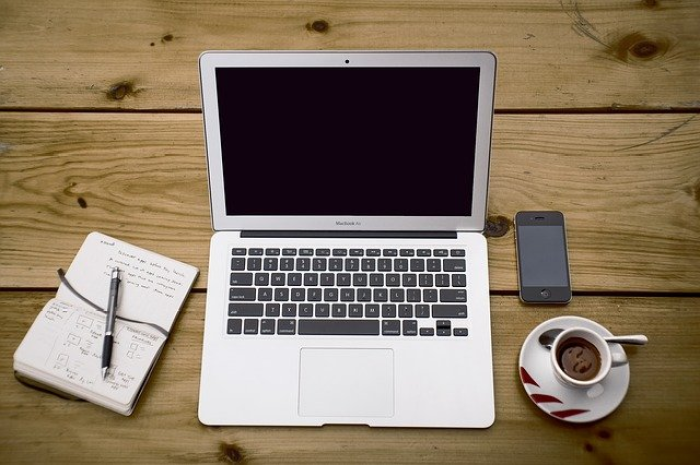

In [3]:
# Little function to resize in keeping the format ratio
# Cf. https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700)) 

In [4]:
(H, W) = IMAGE.shape[:2]
(H, W)

(426, 640)

## Read labels

Read the list of labels (coco) YOLO would be able to detect in the image

In [5]:
with open(COCO_LABELS_FILE, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')

## Color square initialisation (random)

Define for each label an specific color for the quares in the photo.

In [6]:
np.random.seed(45)
BOX_COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Prepare YOLO / OpenCV

Read the YOLO config & weights. (only for the V3 for the moment)

In [7]:
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

Get the output layer only

In [8]:
yololayers = [yolo.getLayerNames()[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]
yololayers

['yolo_82', 'yolo_94', 'yolo_106']

Prepare the Image (blog) to send it to the YOLO net

In [9]:
blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416),	swapRB=True, crop=False)
yolo.setInput(blobimage)

# Apply YOLO / OpenCV

In [10]:
layerOutputs = yolo.forward(yololayers)
layerOutputs[0].shape

(507, 85)

In [11]:
boxes_detected = []
confidences_scores = []
labels_detected = []

In [12]:
# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
    # extract the class ID and confidence (i.e., probability) of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]

    # Take only predictions with confidence more than CONFIDENCE_MIN thresold
    if confidence > CONFIDENCE_MIN:
      # Bounding box
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      # update our result list (detection)
      boxes_detected.append([x, y, int(width), int(height)])
      confidences_scores.append(float(confidence))
      labels_detected.append(classID)

## Brut Results

In [13]:
nb_results = len(boxes_detected)
nb_results

2

In [14]:
labels_detected

[63, 67]

Use labels names instead ...

In [15]:
label_names = [labels[i] for i in labels_detected]
label_names

['laptop', 'cell phone']

In [16]:
confidences_scores

[0.9960631132125854, 0.985262393951416]

In [17]:
boxes_detected

[[174, 50, 274, 334], [469, 193, 53, 83]]

# Display results in the image

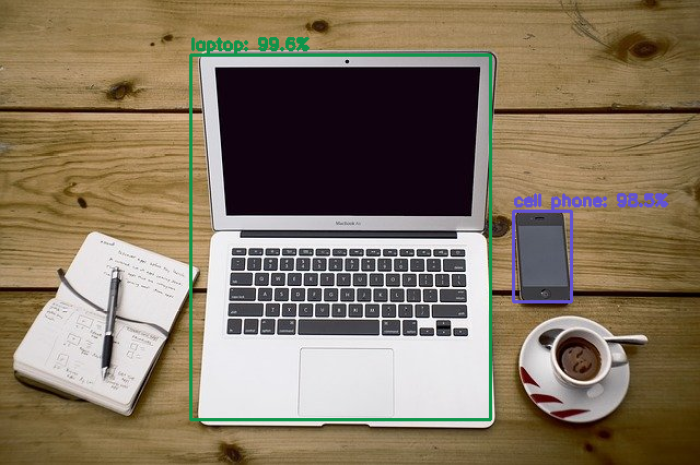

In [18]:
image = IMAGE.copy()
if nb_results > 0:
  for i in range(nb_results):
    # extract the bounding box coordinates
    (x, y) = (boxes_detected[i][0], boxes_detected[i][1])
    (w, h) = (boxes_detected[i][2], boxes_detected[i][3])
    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in BOX_COLORS[labels_detected[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    score = str(round(float(confidences_scores[i]) * 100, 1)) + "%"
    text = "{}: {}".format(labels[labels_detected[i]], score)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  
cv2_imshow(ResizeWithAspectRatio(image, width=700))